<a href="https://colab.research.google.com/github/mLucas55/spam-email-classification/blob/main/spam-email-classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import and install libraries


In [ ]:
!pip install tensorflow_text

In [2]:
import numpy as np
import pandas as pd

# machine learning libraries
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from sklearn.model_selection import train_test_split
print(tf. __version__)

2.15.0


Data importing and manipulation

In [3]:
# import data set
df = pd.read_csv("combined_data.csv")
df.sample(10, random_state=0)

# 1 = spam
# 0 = not spam

,label,text
51814,1,survey takers are needed in your area now . we...
82206,0,using tomcat but need to do more need to supp...
22371,1,be a star in bed be with penis enlarge patch h...
17509,1,anatrim escapenumber the very up to date and m...
81484,1,the oi | and gas advisory\nnow that oil and ga...
70973,1,while we may have high expectations of our ass...
46225,0,may escapenumber escapenumber home u s world p...
6916,0,author jra date escapenumber escapenumber esca...
10296,1,i ' ve been using your product for 4 months no...
64400,1,take a look at this one special situation aler...


In [4]:
# 'escapenumber' is a common substring in text values that seems to be an error from
# the preprocessing done to this data set. It will be removed.

# replace all instances of 'escapenumber' with an empty string
df['text'] = df['text'].str.replace('escapenumber', '')
df.sample(10, random_state=0)

,label,text
51814,1,survey takers are needed in your area now . we...
82206,0,using tomcat but need to do more need to supp...
22371,1,be a star in bed be with penis enlarge patch h...
17509,1,anatrim the very up to date and most delighti...
81484,1,the oi | and gas advisory\nnow that oil and ga...
70973,1,while we may have high expectations of our ass...
46225,0,may home u s world politics scitech health e...
6916,0,author jra date mon jun new revision ...
10296,1,i ' ve been using your product for 4 months no...
64400,1,take a look at this one special situation aler...


Determine the DataFrame's balance of binary values and create a balanced DataFrame

In [5]:
# total spam(1) and not spam(0) in DataFrame
print(df['label'].value_counts(), "\n")

# percentages of spam and not spam
print(round(df['label'].value_counts(normalize=True) * 100))

1    43910
0    39538
Name: label, dtype: int64 

1    53.0
0    47.0
Name: label, dtype: float64


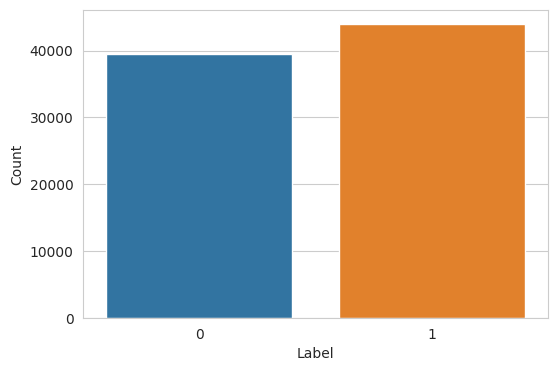

In [48]:
# visualization
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
plt.figure(figsize=(6,4))
sns.countplot(x="label", data=df)
plt.xlabel('Label').set_fontsize('10')
plt.ylabel('Count').set_fontsize('10')
plt.show()

In [7]:
# create DataFrames for spam and non-spam to be used for their shape values
df_spam = df[df['label']==1]
df_notSpam = df[df['label']==0]

# print shapes
print("Spam DataFrame:    ", df_spam.shape[0])
print("Not Spam DataFrame:", df_notSpam.shape[0])

Spam DataFrame:     43910
Not Spam DataFrame: 39538


In [8]:
# create down sampled DataFrame of spam values equal to amount of non-spam values
# by using a sample size equal to the first index in the notSpam shape-tuple

df_spam_ds = df_spam.sample(700)
df_notSpam_ds = df_notSpam.sample(700)

# print shape
print("Down sampled spam:    ", df_spam_ds.shape[0])
print("Down sampled not spam:", df_notSpam_ds.shape[0])

Down sampled spam:     700
Down sampled not spam: 700


In [9]:
# create DataFrame with 50/50 split of spam and not spam values by combining original
# notSpam DataFrama with downsampled spam DataFrame

df_balanced = pd.concat([df_notSpam_ds, df_spam_ds])

# display new DataFrame counts
df_balanced['label'].value_counts()

0    700
1    700
Name: label, dtype: int64

In [10]:
df_balanced.sample(5)

,label,text
2867,1,do you like sexy animals doing the wild thing ...
52906,1,viagra is just cheapest viagra and cialis of...
74903,1,http www imagehost ro viewer php img escapelon...
83402,1,get the finest rolex watch replica we only se...
48194,0,attached are the super saturday results ( offe...


Machine learning

In [11]:
# create train and test sets
# use stratify to ensure balanced class distrubtion across train and test sets

X_train, X_test, y_train, y_test = train_test_split(df_balanced['text'], df_balanced['label'], stratify=df_balanced['label'])

In [12]:
# hello BERT
bert_preprocesser = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [13]:
# bert layers for text processing
email_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='email')
preprocessed_email = bert_preprocesser(email_input)
outputs = bert_encoder(preprocessed_email)

# nerual network layers using vectors created by bert transformer
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output']) # dropout to prevent overfitting
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l) # 1 neuron for binary classification

# model
model = tf.keras.Model(inputs=[email_input], outputs = [l])

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 email (InputLayer)          [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_mask': (None, 128)   0         ['email[0][0]']               
                             , 'input_type_ids': (None,                                           
                              128),                                                               
                              'input_word_ids': (None,                                            
                             128)}                                                                
                                                                                              

In [17]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision')
]

# configure model for training
model.compile(optimizer='adam',
              loss='binary_crossentropy', # training
              metrics=METRICS
              )

In [18]:
# train model -> sample size 700
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
33/33 [==============================] - 331s 10s/step - loss: 0.5189 - accuracy: 0.7771 - precision: 0.7641
Epoch 2/10
33/33 [==============================] - 327s 10s/step - loss: 0.5185 - accuracy: 0.7724 - precision: 0.7849
Epoch 3/10
33/33 [==============================] - 328s 10s/step - loss: 0.5035 - accuracy: 0.7743 - precision: 0.7748
Epoch 4/10
33/33 [==============================] - 327s 10s/step - loss: 0.4905 - accuracy: 0.7886 - precision: 0.7953
Epoch 5/10
33/33 [==============================] - 328s 10s/step - loss: 0.4808 - accuracy: 0.7905 - precision: 0.8106
Epoch 6/10
33/33 [==============================] - 327s 10s/step - loss: 0.4775 - accuracy: 0.7933 - precision: 0.7895
Epoch 7/10
33/33 [==============================] - 327s 10s/step - loss: 0.4627 - accuracy: 0.8200 - precision: 0.8182
Epoch 8/10
33/33 [==============================] - 327s 10s/step - loss: 0.4567 - accuracy: 0.8162 - precision: 0.8230
Epoch 9/10
33/33 [======================

In [19]:
model.evaluate(X_test, y_test)

11/11 [==============================] - 109s 10s/step - loss: 0.4701 - accuracy: 0.7971 - precision: 0.8881


[0.4701497554779053, 0.7971428632736206, 0.888059675693512]